# Data Reduction 2 - C2H6

**Baseline Correction**

3 different subnotebook
- ASW
- **C2H6**
- C2H6_ASW

## Imports

In [77]:
%matplotlib inline

import numpy 
import math
from math import isnan
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import pandas as pd
import glob
from functools import reduce
import ipywidgets as widgets
import matplotlib.gridspec as gridspec
from datetime import datetime
from IPython.core.display import SVG
import re
import json


## Input Parameters

$\color{red}{\text{Implement manually !}}$

In [78]:
# 0.1 Date
date = "2020_12_03"

# 0.2 XP
XP = "XP_1-2"

# 0.3 Sample type
spl = "C2H6"

# 0.4 Deposition Temperature
Tdep = "20"

# Colormap normalisation

Tmin = 20
Tmax = 70


# Is there any Isotherm ?

Iso = False

## Load Data

In [79]:
# All_RAW_df

All_RAW_df = pd.read_csv("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR1_{}_All-scans.csv".format(XP,date,date))

All_RAW_df = All_RAW_df.iloc[:,1:]

# data_annex
data_annex_df = pd.read_csv("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR1_{}_data_annex.csv".format(XP,date,date))

# XP_list_test

XP_Ramp_df = pd.read_csv('..\..\DATA\DATA-Processing\PAC\XP_list_test.csv')

XP_Ramp_df_date = XP_Ramp_df.loc[XP_Ramp_df['Date'] == date]
XP_Ramp_df_date2 = XP_Ramp_df_date.set_index("Date")
#XP_Ramp_df_date2
XP_Ramp_df_T = XP_Ramp_df_date2.T
#XP_Ramp_df_T
XP_Ramp_df_T_f = XP_Ramp_df_T.iloc[1: , :]
#XP_Ramp_df_T_f
XP_Ramp_df_T_f2=XP_Ramp_df_T_f.dropna()
XP_Ramp_df_T_f2

# Produce dictionnary

Tdictionary = dict(zip(XP_Ramp_df_T_f2.index, XP_Ramp_df_T_f2[date]))

## Sanity Check

In [80]:
# All_RAW_df
# data_annex_df
# XP_Ramp_df
# Tdictionary

Let's take it slow and start by plotting the DR1 Data

19


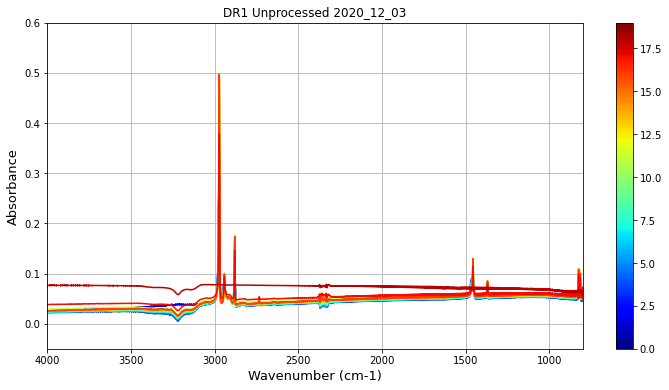

In [81]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(12,6))


normalize = mcolors.Normalize(vmin=0, vmax=nscan)
colormap = cm.jet
i=1

for i in range(1,nscan):
    
    plt.plot(All_RAW_df.Wavenumber, All_RAW_df['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(i)))
    
    i=+1
    

plt.title('DR1 Unprocessed {0}'.format(date))
plt.axis([4000,800,-0.05,0.6])
plt.xlabel('Wavenumber (cm-1)').set_fontsize(13)
plt.ylabel('Absorbance').set_fontsize(13)
#ax = fig.gca()
plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
plt.colorbar(scalarmappaple)

# Into proper Data_Processing folder

plt.savefig('..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR1_{}_Full-range_U.png'.format(XP, date, date))

# Also into Data Notes folder

#plt.savefig('../../Notes/Data_Notes/{}/{}/Plots/DR/DR1_{}_Full-range.png'.format(XP2, date, date))

plt.show()

## <u>Background function definition </u>

No need for sub-ranges :)

In [82]:
maxA = []
maxAi = []

# We supress the first column (Wavenumber)

All_RAW_df_U = All_RAW_df.T.iloc[1:].T


dataStats = pd.DataFrame.from_dict(
  dict(min1=All_RAW_df.T.iloc[1:].T.iloc[6223:6639].min(axis=0), # min within rows 6000 - end
       mini1=All_RAW_df.T.iloc[1:].T.iloc[6223:6639].idxmin(axis=0), # index of that min
       min2=All_RAW_df.T.iloc[1:].T.iloc[0:1038].min(axis=0), # min within rows 415 - 830
       mini2=All_RAW_df.T.iloc[1:].T.iloc[0:1038].idxmin(axis=0), # index of that min   
        )
    
)

def computeLinearBackground1(values,     # The column values (e.g. Y)
                            waveNumber, # The corresponding wavenumbers (e.g. X)
                            valueStats  # The dataframe containing the minima and their 
                                        # indices for each file
                 ):
    
    stats = valueStats.loc[values.name, :]
    # compute a linear background function
    gradient = ((stats.min1 - stats.min2)/(stats.mini1 - stats.mini2))
    intercept = stats.min1 - stats.mini1*gradient
    linearBackground1 = (gradient * waveNumber.index) + intercept
    # subtract that function from the column values
    return linearBackground1


# Finally apply our function to the columns of the dataframe (except the wavenumber column)
# We specify axis=0 to operate on the columns (confusingly this is referred to as *along*
# the index direction in the docs), and pass the first (wavenumber) column and the summary 
# statistics dataframe, wrapped in a tuple, as the `args` argument.
backgroundsE = All_RAW_df_U.T.iloc[0:].T.apply(computeLinearBackground1, axis=0, args=(All_RAW_df_U.T.iloc[0], dataStats))

## <u>Baseline correction</u>

### data - background subtraction 

In [83]:
All_df_BC = pd.DataFrame(All_RAW_df_U - backgroundsE)

### Cleaning and Sanity Check

We reinsert the Wavenumber that was removed prior to the baseline function aplied

In [84]:
All_df_BC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])

backgroundsE.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])

In [85]:
All_df_BC

,Wavenumber,C2H6_2020_12_03_1,C2H6_2020_12_03_2,C2H6_2020_12_03_3,C2H6_2020_12_03_4,C2H6_2020_12_03_5,C2H6_2020_12_03_6,C2H6_2020_12_03_7,C2H6_2020_12_03_8,C2H6_2020_12_03_9,C2H6_2020_12_03_10,C2H6_2020_12_03_11,C2H6_2020_12_03_12,C2H6_2020_12_03_13,C2H6_2020_12_03_14,C2H6_2020_12_03_15,C2H6_2020_12_03_16,C2H6_2020_12_03_17,C2H6_2020_12_03_18
0,799.8442,-3.601991e-03,-4.393042e-03,0.000000,0.000000,5.308329e-04,0.001194,0.002305,0.002693,0.004146,0.003345,7.192280e-03,7.273223e-03,7.279912e-03,0.010740,1.205471e-02,0.011991,1.605091e-02,0.016159
1,800.3264,8.169777e-04,-1.322031e-04,0.005217,0.004523,4.117686e-03,0.004742,0.005374,0.003565,0.004787,0.004593,4.647068e-03,3.846157e-03,4.956246e-03,0.006670,7.775803e-03,0.008411,1.382436e-02,0.014122
2,800.8085,5.354427e-03,4.415006e-03,0.010173,0.009205,7.926839e-03,0.008633,0.008537,0.004949,0.005693,0.005694,2.357166e-03,7.131814e-04,2.426409e-03,0.002144,3.181661e-03,0.003820,1.005791e-02,0.010118
3,801.2906,4.117115e-03,4.244515e-03,0.009069,0.008537,8.044972e-03,0.008584,0.007894,0.005906,0.005762,0.005713,2.616895e-03,4.209958e-04,1.959913e-03,0.000540,7.693192e-04,0.000809,3.180930e-03,0.002895
4,801.7727,3.120740e-04,7.293740e-04,0.005544,0.004962,5.003466e-03,0.005641,0.004644,0.004870,0.004131,0.004601,2.480063e-03,4.013201e-04,1.586866e-03,0.000613,6.048573e-04,0.000414,-6.938894e-18,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,3998.2570,2.122050e-04,2.505639e-04,0.000159,0.000170,1.252937e-04,0.000125,0.000162,0.000380,0.000423,0.000394,4.376073e-04,4.735925e-04,5.036659e-04,0.000408,4.808338e-04,0.000471,1.911894e-04,0.000205
6635,3998.7390,1.534437e-04,2.102129e-04,0.000093,0.000121,9.011683e-05,0.000078,0.000104,0.000196,0.000223,0.000212,3.196455e-04,3.633068e-04,4.141394e-04,0.000211,2.532619e-04,0.000251,1.252797e-04,0.000105
6636,3999.2210,8.054249e-05,9.552195e-05,0.000000,0.000008,3.469447e-18,0.000000,0.000000,0.000000,0.000000,0.000000,1.654936e-04,2.117912e-04,2.584929e-04,0.000000,-3.469447e-18,0.000000,-6.938894e-18,0.000000
6637,3999.7030,9.619124e-05,8.772097e-05,0.000082,0.000058,3.678532e-04,0.000395,0.000405,0.000957,0.000951,0.000947,8.894182e-05,1.208656e-04,1.436965e-04,0.000893,8.096681e-04,0.000788,4.260803e-04,0.000801


In [86]:
#backgroundsE

#### Export as csv

In [87]:
All_df_BC.to_csv('../../DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR2_{}_All-scans_U.csv'.format(XP, date, date))

## <u>Max Absorbance</u>


Determine the index based on the wavenumber value
- Implement link

Create sub ranges for the different peaks

___Find index based on column value___

In [88]:
All_df_BC[(All_df_BC['Wavenumber'] > 828) & (All_df_BC['Wavenumber'] < 832)].index.tolist()


[59, 60, 61, 62, 63, 64, 65, 66]

In [89]:
All_df_BC.loc[63, 'Wavenumber']

830.2181

### Chop the data 

Ethane has 3 main peaks so data is splitted in 3 range:


**Check assignment**

- E1: 
- E2: 
- E3: 

In [90]:

DR2_E1_df = All_df_BC[4470:4564]

DR2_E2_df = All_df_BC[4356:4470]

DR2_E3_df = All_df_BC[4273:4356]

DR2_E4_df = All_df_BC[1297:1452]

DR2_E5_df = All_df_BC[1141:1245]

DR2_E6_df = All_df_BC[21:42]

DR2_E7_df = All_df_BC[42:63]



In [91]:
DR2_E7_df

,Wavenumber,C2H6_2020_12_03_1,C2H6_2020_12_03_2,C2H6_2020_12_03_3,C2H6_2020_12_03_4,C2H6_2020_12_03_5,C2H6_2020_12_03_6,C2H6_2020_12_03_7,C2H6_2020_12_03_8,C2H6_2020_12_03_9,C2H6_2020_12_03_10,C2H6_2020_12_03_11,C2H6_2020_12_03_12,C2H6_2020_12_03_13,C2H6_2020_12_03_14,C2H6_2020_12_03_15,C2H6_2020_12_03_16,C2H6_2020_12_03_17,C2H6_2020_12_03_18
42,820.0934,0.027625,0.027357,0.034374,0.034454,0.033162,0.033566,0.034008,0.006529,0.005372,0.006024,0.004224,0.002736,0.003437,0.001723,0.001679,0.001568,0.003216,0.006279
43,820.5756,0.023702,0.023356,0.030589,0.030632,0.029426,0.029791,0.030242,0.006793,0.005782,0.006310,0.005372,0.004352,0.004983,0.003861,0.003849,0.003901,0.004845,0.006209
44,821.0577,0.021580,0.021201,0.028589,0.028580,0.027160,0.027397,0.027923,0.006029,0.005152,0.005490,0.004570,0.003517,0.004033,0.003336,0.003348,0.003389,0.005266,0.006647
45,821.5399,0.018636,0.018310,0.025752,0.025652,0.024330,0.024519,0.025056,0.004368,0.003699,0.003812,0.003606,0.002383,0.002686,0.002937,0.002957,0.002934,0.005286,0.007862
46,822.0220,0.018066,0.017791,0.025348,0.025098,0.023505,0.023656,0.024174,0.005331,0.004821,0.004667,0.004301,0.003009,0.003131,0.004341,0.004471,0.004351,0.008114,0.008417
47,822.5041,0.016310,0.016085,0.023794,0.023328,0.021850,0.021972,0.022548,0.010614,0.010521,0.010134,0.010991,0.010093,0.010251,0.013506,0.014055,0.013870,0.017242,0.009523
48,822.9862,0.016470,0.016291,0.024181,0.023475,0.021867,0.021912,0.022608,0.020798,0.021058,0.020503,0.021342,0.020658,0.021080,0.024968,0.025829,0.025542,0.026584,0.008622
49,823.4683,0.014649,0.014652,0.022600,0.021713,0.020272,0.020271,0.021076,0.031595,0.032332,0.031686,0.033220,0.032807,0.033494,0.037910,0.038956,0.038562,0.036043,0.008898
50,823.9504,0.014236,0.014446,0.022364,0.021485,0.019925,0.019854,0.020779,0.041623,0.042660,0.042095,0.042819,0.042371,0.043224,0.046745,0.047722,0.047246,0.041572,0.007216
51,824.4326,0.011432,0.011767,0.019576,0.018894,0.017398,0.017371,0.018255,0.047896,0.049228,0.048762,0.049865,0.049442,0.050488,0.054069,0.055243,0.054807,0.046785,0.007784


### Max A 

Wavenumber is selcted, do we want it ? Probably not

In [92]:
dataE1_Max = pd.DataFrame.from_dict(
  dict(maxE1=DR2_E1_df.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxE1i=DR2_E1_df.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

dataE2_Max = pd.DataFrame.from_dict(
  dict(maxE2=DR2_E2_df.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxE2i=DR2_E2_df.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

dataE3_Max = pd.DataFrame.from_dict(
  dict(maxE3=DR2_E3_df.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxE3i=DR2_E3_df.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

dataE4_Max = pd.DataFrame.from_dict(
  dict(maxE4=DR2_E4_df.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxE4i=DR2_E4_df.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

dataE5_Max = pd.DataFrame.from_dict(
  dict(maxE5=DR2_E5_df.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxE5i=DR2_E5_df.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

dataE6_Max = pd.DataFrame.from_dict(
  dict(maxE6=DR2_E6_df.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxE6i=DR2_E6_df.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

dataE7_Max = pd.DataFrame.from_dict(
  dict(maxE7=DR2_E7_df.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxE7i=DR2_E7_df.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

#### Sanity Check

In [93]:
#dataE2_Max

#### Clean

Could create a function rather than doing it 3 times !!

In [94]:
wavelength = All_df_BC.T.iloc[0]

# E1

dataE1_Max = dataE1_Max.reset_index()
dataE1_Max['Name'] = dataE1_Max['index']
dataE1_Max = dataE1_Max.T.iloc[1:].T

dataE1_Max1 = dataE1_Max.set_index('maxE1i',drop=True)
dataE1_Max2 = dataE1_Max1.join(wavelength, on='maxE1i')
dataE1_Max2 = dataE1_Max2.reset_index()
dataE1_Max_F = dataE1_Max2.set_index(dataE1_Max.index)
dataE1_Max_F.rename(columns={'Wavenumber': 'maxE1w'}, inplace=True)

# E2

dataE2_Max = dataE2_Max.reset_index()
dataE2_Max['Name'] = dataE2_Max['index']
dataE2_Max = dataE2_Max.T.iloc[1:].T

dataE2_Max1 = dataE2_Max.set_index('maxE2i',drop=True)
dataE2_Max2 = dataE2_Max1.join(wavelength, on='maxE2i')
dataE2_Max2 = dataE2_Max2.reset_index()
dataE2_Max_F = dataE2_Max2.set_index(dataE2_Max.index)
dataE2_Max_F.rename(columns={'Wavenumber': 'maxE2w'}, inplace=True)

# E3

dataE3_Max = dataE3_Max.reset_index()
dataE3_Max['Name'] = dataE3_Max['index']
dataE3_Max = dataE3_Max.T.iloc[1:].T

dataE3_Max1 = dataE3_Max.set_index('maxE3i',drop=True)
dataE3_Max2 = dataE3_Max1.join(wavelength, on='maxE3i')
dataE3_Max2 = dataE3_Max2.reset_index()
dataE3_Max_F = dataE3_Max2.set_index(dataE3_Max.index)
dataE3_Max_F.rename(columns={'Wavenumber': 'maxE3w'}, inplace=True)

# E4

dataE4_Max = dataE4_Max.reset_index()
dataE4_Max['Name'] = dataE4_Max['index']
dataE4_Max = dataE4_Max.T.iloc[1:].T

dataE4_Max1 = dataE4_Max.set_index('maxE4i',drop=True)
dataE4_Max2 = dataE4_Max1.join(wavelength, on='maxE4i')
dataE4_Max2 = dataE4_Max2.reset_index()
dataE4_Max_F = dataE4_Max2.set_index(dataE4_Max.index)
dataE4_Max_F.rename(columns={'Wavenumber': 'maxE4w'}, inplace=True)

# E5

dataE5_Max = dataE5_Max.reset_index()
dataE5_Max['Name'] = dataE5_Max['index']
dataE5_Max = dataE5_Max.T.iloc[1:].T

dataE5_Max1 = dataE5_Max.set_index('maxE5i',drop=True)
dataE5_Max2 = dataE5_Max1.join(wavelength, on='maxE5i')
dataE5_Max2 = dataE5_Max2.reset_index()
dataE5_Max_F = dataE5_Max2.set_index(dataE5_Max.index)
dataE5_Max_F.rename(columns={'Wavenumber': 'maxE5w'}, inplace=True)

# E6

dataE6_Max = dataE6_Max.reset_index()
dataE6_Max['Name'] = dataE6_Max['index']
dataE6_Max = dataE6_Max.T.iloc[1:].T

dataE6_Max1 = dataE6_Max.set_index('maxE6i',drop=True)
dataE6_Max2 = dataE6_Max1.join(wavelength, on='maxE6i')
dataE6_Max2 = dataE6_Max2.reset_index()
dataE6_Max_F = dataE6_Max2.set_index(dataE6_Max.index)
dataE6_Max_F.rename(columns={'Wavenumber': 'maxE6w'}, inplace=True)

# E7

dataE7_Max = dataE7_Max.reset_index()
dataE7_Max['Name'] = dataE7_Max['index']
dataE7_Max = dataE7_Max.T.iloc[1:].T

dataE7_Max1 = dataE7_Max.set_index('maxE7i',drop=True)
dataE7_Max2 = dataE7_Max1.join(wavelength, on='maxE7i')
dataE7_Max2 = dataE7_Max2.reset_index()
dataE7_Max_F = dataE7_Max2.set_index(dataE7_Max.index)
dataE7_Max_F.rename(columns={'Wavenumber': 'maxE7w'}, inplace=True)

___Insert column scan number___ 

to be able to link data_annex with XP_Ramp_df

In [95]:
nscan = len(list(dataE1_Max_F.index.values.tolist()))
scan_number = pd.Series(range(1,nscan+1))
scan_number.astype(int)

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
12    13
13    14
14    15
15    16
16    17
17    18
dtype: int32

In [96]:
dataE1_Max_F['scan_number'] = scan_number

###  Append to data Annex

<div class="alert alert-block alert-danger">
Unnamed column
</div>



In [97]:
data_annex_df = data_annex_df.T.iloc[1:].T

In [98]:
data_annex_df

,Name,min1,index1,min2,index2,min3,index3,min4,index4,min5,index5,min6,index6,max,max_index
0,C2H6_2020_12_03_1,0.0255654,6638,0.0362991,4290,0.0385687,4146,0.0508658,2481,0.0520633,2278,0.0570417,1036,0.335483,4505
1,C2H6_2020_12_03_2,0.0251207,6638,0.0361008,4290,0.038392,4146,0.050818,2481,0.0520591,2278,0.0571027,1036,0.335075,4505
2,C2H6_2020_12_03_3,0.0251676,6636,0.0361014,4290,0.0377786,4146,0.0473932,2471,0.0482866,2278,0.0453103,0,0.33626,4505
3,C2H6_2020_12_03_4,0.0215263,6638,0.0332503,4290,0.0350901,4146,0.0453498,2481,0.0463532,2278,0.0446734,0,0.333253,4505
4,C2H6_2020_12_03_5,0.0227546,6636,0.0343596,4290,0.0360709,4146,0.0465505,2481,0.0475458,2278,0.0482549,18,0.334019,4505
5,C2H6_2020_12_03_6,0.0227676,6636,0.0344601,4290,0.0361587,4146,0.046665,2481,0.0476846,2278,0.0482343,24,0.334078,4505
6,C2H6_2020_12_03_7,0.0232131,6636,0.0347788,4290,0.0364572,4146,0.0469742,2481,0.0479964,2278,0.0485348,6,0.3344,4505
7,C2H6_2020_12_03_8,0.0235495,6636,0.0337904,4305,0.0373312,4145,0.0477086,2481,0.0488106,2270,0.0484953,22,0.485107,4506
8,C2H6_2020_12_03_9,0.0235313,6636,0.0335607,4305,0.0375068,4145,0.0480175,2481,0.0491248,2270,0.0490759,22,0.490076,4506
9,C2H6_2020_12_03_10,0.0247725,6636,0.0348043,4305,0.0388396,4145,0.0494227,2481,0.0505299,2270,0.0508362,22,0.491511,4506


In [99]:
data_annex_df = pd.merge(data_annex_df, dataE1_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataE2_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataE3_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataE4_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataE5_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataE6_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataE7_Max_F, on="Name")

In [100]:
data_annex_df

,Name,min1,index1,min2,index2,min3,index3,min4,index4,min5,...,maxE4w,maxE5i,maxE5,maxE5w,maxE6i,maxE6,maxE6w,maxE7i,maxE7,maxE7w
0,C2H6_2020_12_03_1,0.0255654,6638,0.0362991,4290,0.0385687,4146,0.0508658,2481,0.0520633,...,1463.729,1183,0.0207815,1370.197,36,0.0382103,817.2007,43,0.0237016,820.5756
1,C2H6_2020_12_03_2,0.0251207,6638,0.0361008,4290,0.038392,4146,0.050818,2481,0.0520591,...,1463.729,1183,0.0207629,1370.197,36,0.0383029,817.2007,43,0.0233557,820.5756
2,C2H6_2020_12_03_3,0.0251676,6636,0.0361014,4290,0.0377786,4146,0.0473932,2471,0.0482866,...,1463.729,1183,0.0304289,1370.197,36,0.0453921,817.2007,43,0.0305885,820.5756
3,C2H6_2020_12_03_4,0.0215263,6638,0.0332503,4290,0.0350901,4146,0.0453498,2481,0.0463532,...,1463.729,1183,0.029997,1370.197,36,0.0446346,817.2007,43,0.0306316,820.5756
4,C2H6_2020_12_03_5,0.0227546,6636,0.0343596,4290,0.0360709,4146,0.0465505,2481,0.0475458,...,1463.729,1183,0.0281047,1370.197,36,0.0444563,817.2007,43,0.0294259,820.5756
5,C2H6_2020_12_03_6,0.0227676,6636,0.0344601,4290,0.0361587,4146,0.046665,2481,0.0476846,...,1459.872,1183,0.0283335,1370.197,36,0.044535,817.2007,43,0.0297914,820.5756
6,C2H6_2020_12_03_7,0.0232131,6636,0.0347788,4290,0.0364572,4146,0.0469742,2481,0.0479964,...,1463.729,1183,0.0282968,1370.197,36,0.0450923,817.2007,43,0.0302421,820.5756
7,C2H6_2020_12_03_8,0.0235495,6636,0.0337904,4305,0.0373312,4145,0.0477086,2481,0.0488106,...,1456.498,1181,0.0372283,1369.233,33,0.0494341,815.7543,53,0.0523819,825.3969
8,C2H6_2020_12_03_9,0.0235313,6636,0.0335607,4305,0.0375068,4145,0.0480175,2481,0.0491248,...,1456.498,1181,0.0372955,1369.233,33,0.0501435,815.7543,53,0.0536778,825.3969
9,C2H6_2020_12_03_10,0.0247725,6636,0.0348043,4305,0.0388396,4145,0.0494227,2481,0.0505299,...,1456.498,1181,0.0371305,1369.233,33,0.0507281,815.7543,53,0.0535783,825.3969


In [101]:
print(data_annex_df.loc[0])

Name           C2H6_2020_12_03_1
min1                   0.0255654
index1                      6638
min2                   0.0362991
index2                      4290
min3                   0.0385687
index3                      4146
min4                   0.0508658
index4                      2481
min5                   0.0520633
index5                      2278
min6                   0.0570417
index6                      1036
max                     0.335483
max_index                   4505
maxE1i                      4505
maxE1                   0.297932
maxE1w                   2971.81
scan_number                    1
maxE2i                      4443
maxE2                  0.0545266
maxE2w                   2941.92
maxE3i                      4314
maxE3                   0.107159
maxE3w                   2879.73
maxE4i                      1377
maxE4                   0.036049
maxE4w                   1463.73
maxE5i                      1183
maxE5                  0.0207815
maxE5w    

## <u>Plotting</u> 

### Full range 

In [102]:
nscan = len(list(dataE1_Max_F.values.tolist()))

ymax =   data_annex_df.iloc[1:,13].astype(float).max()
ymin =   data_annex_df.iloc[1:,1].astype(float).min()
ymax2 = ymax + 0.01
ymin2 = ymin - 0.01 

In [103]:
ymax

0.496948

19


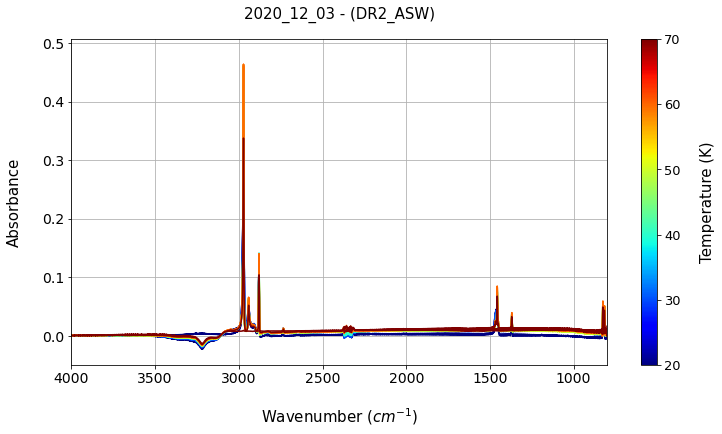

In [104]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(12,6))

for keys, values in Tdictionary.items():
    
    temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=20, vmax=70)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(All_df_BC.Wavenumber, All_df_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(temp)))
    
    
    

plt.title('{0} - (DR2_ASW)'.format(date), fontsize=15, pad=20)
plt.axis([4000,800,-0.05,ymax2])
plt.xlabel('Wavenumber ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
cbar = plt.colorbar(scalarmappaple)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('Temperature (K)', labelpad=20 ,size=15)

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_Full-range.png".format(XP,date,date))


plt.show()

### Sub-range 1

19


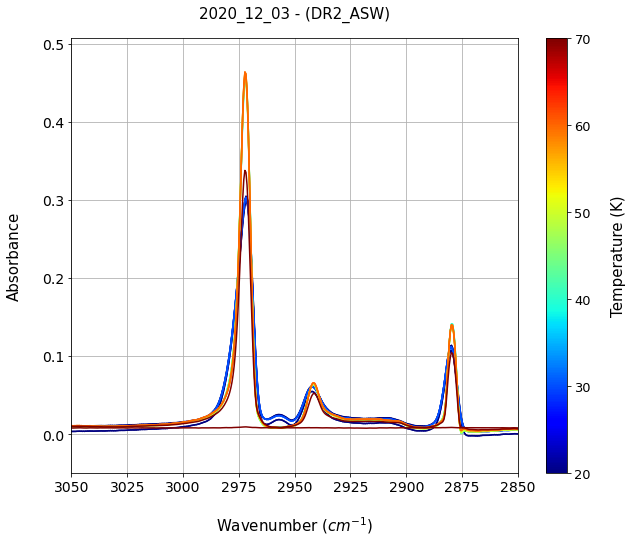

In [105]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=20, vmax=70)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(All_df_BC.Wavenumber, All_df_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(temp)))
    
    
    

plt.title('{0} - (DR2_ASW)'.format(date), fontsize=15, pad=20)
plt.axis([3050,2850,-0.05,ymax2])
plt.xlabel('Wavenumber ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
cbar = plt.colorbar(scalarmappaple)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('Temperature (K)', labelpad=20 ,size=15)

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_sub-range_1.png".format(XP,date,date))


plt.show()

### Ethane range

#### Baseline correction

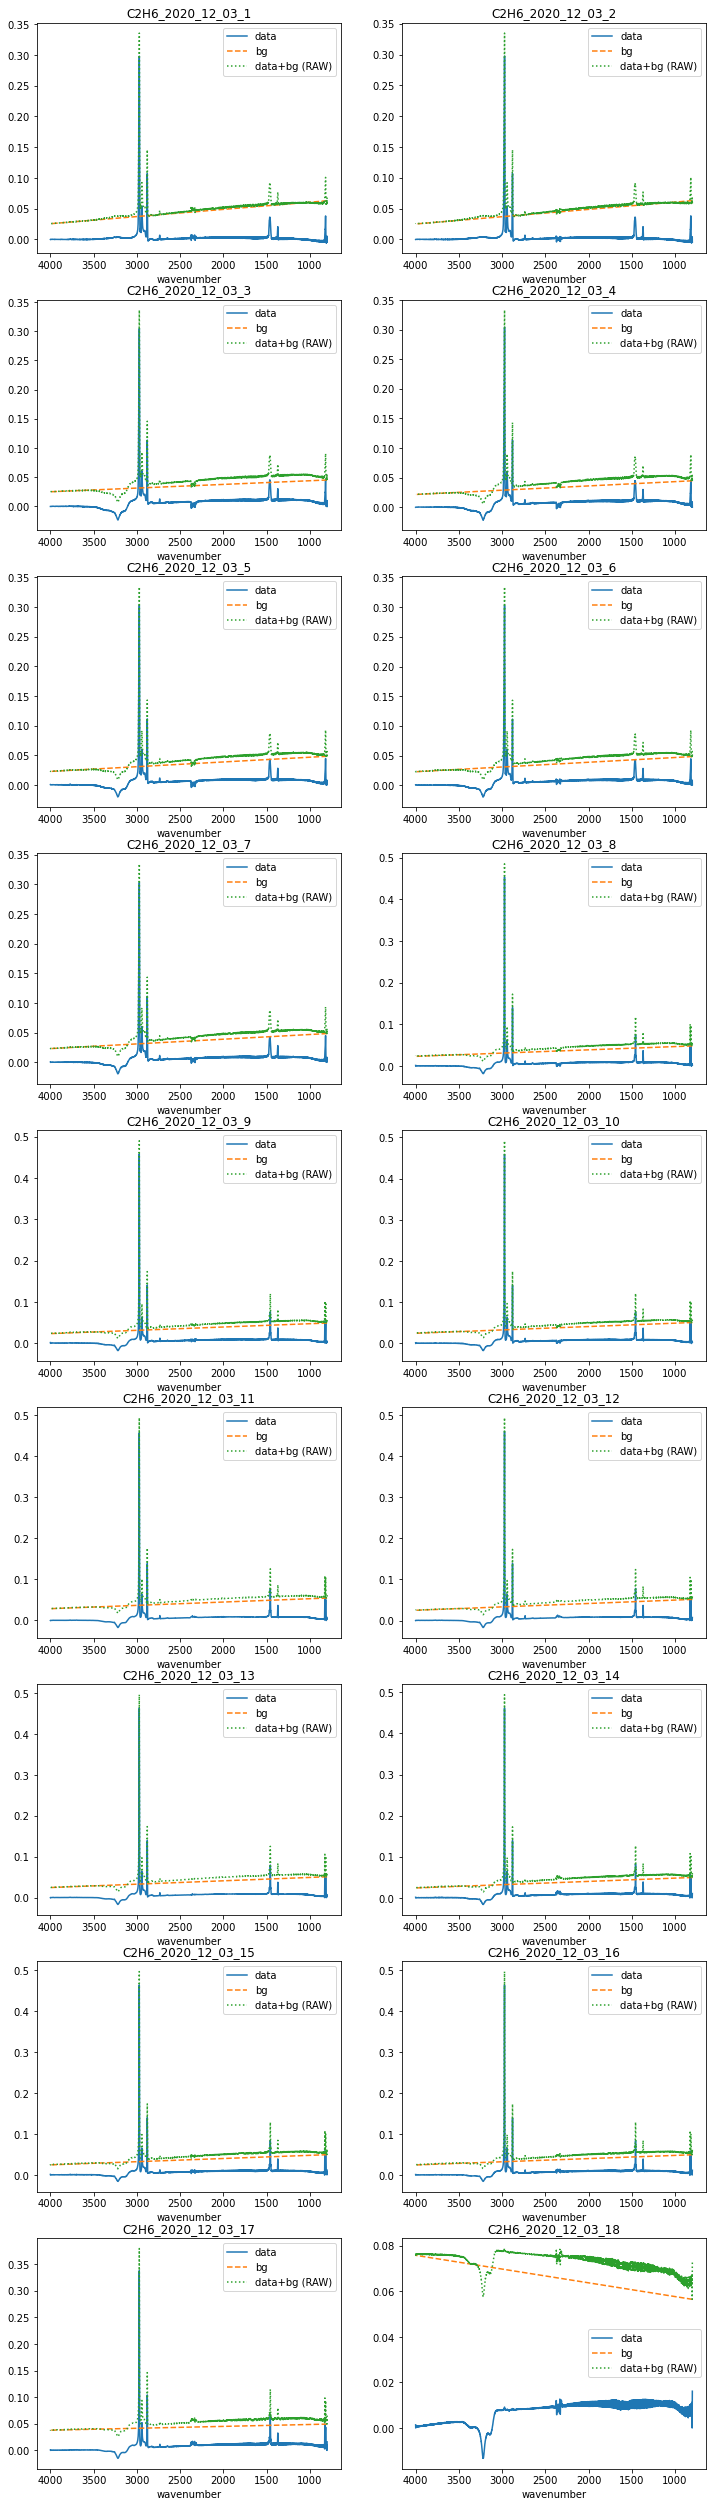

In [106]:
nscan = len(list(All_df_BC.columns.values.tolist()))

nscan2 = nscan//int(2)
nscan1 = nscan2*int(5)

figure, panels = plt.subplots(figsize=(12, nscan1), ncols=2, nrows=nscan2)

for panel, column in zip(panels.flatten(), All_df_BC.columns[1:]):
    panel.plot(All_df_BC.Wavenumber, All_df_BC[column], label="data")
    panel.plot(All_df_BC.Wavenumber, backgroundsE[column], ls="dashed",  label="bg")

    panel.plot(All_df_BC.Wavenumber, All_df_BC[column]+ backgroundsE[column], ls="dotted",  label="data+bg (RAW)")

    
    
    #panel.legend()
    panel.set_xlabel("wavenumber")
    panel.invert_xaxis()
    panel.set_title(column)
    panel.legend()

    plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_BC_total.png".format(XP,date,date), bbox_inches='tight')
    
plt.show()
    
    
#plt.tight_layout()
    

#### 2.4.A.4 Max Absorbance 

##### sub range 1 Abs

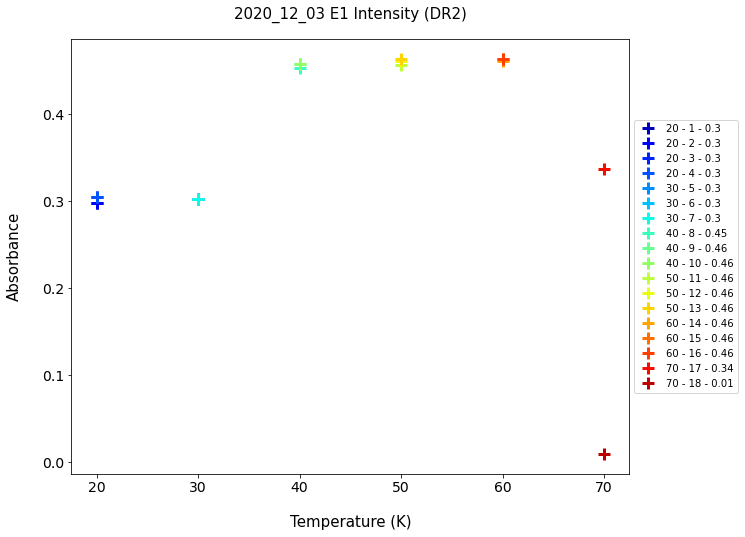

In [107]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,16], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,16]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E1 Intensity (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE1-Abs.png".format(XP,date,date), bbox_inches='tight')


plt.show()

##### sub range 1 frequemcy

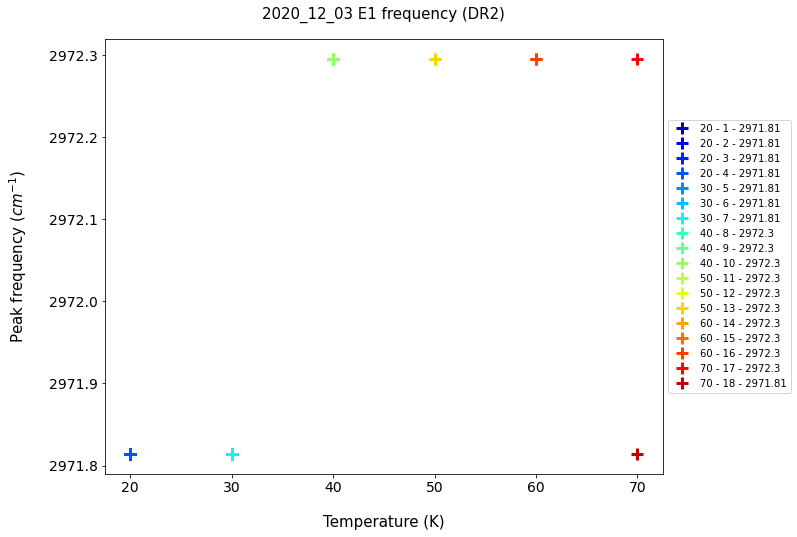

In [108]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,17], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,17]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E1 frequency (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Peak frequency ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE1-freq.png".format(XP,date,date), bbox_inches='tight')


plt.show()

##### sub range 2

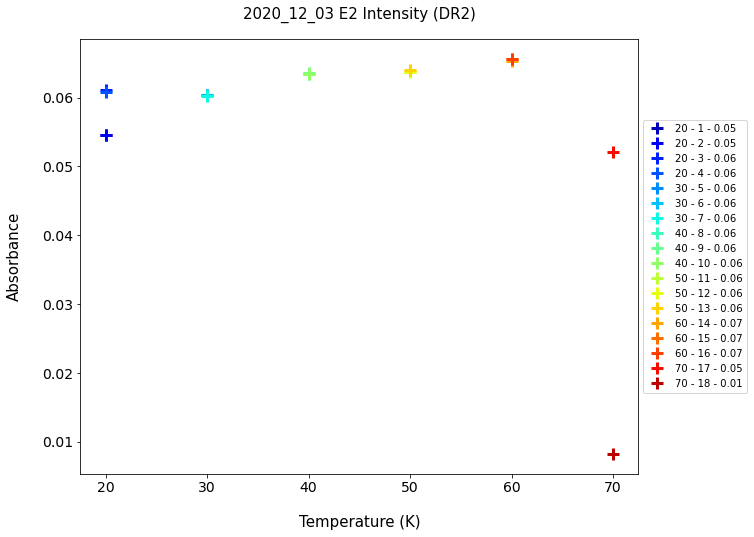

In [109]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,20], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,20]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E2 Intensity (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE2-Abs.png".format(XP,date,date), bbox_inches='tight')


plt.show()

##### sub range 2 frequemcy

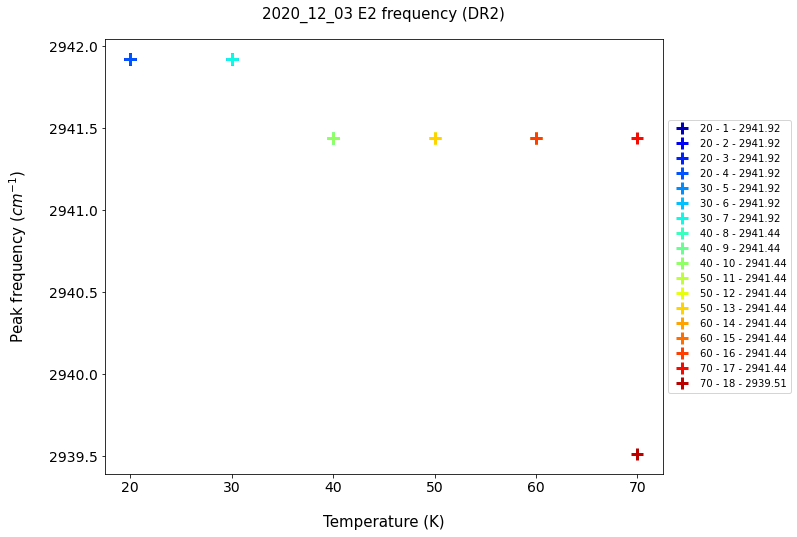

In [110]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,21], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,21]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E2 frequency (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Peak frequency ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE2-freq.png".format(XP,date,date), bbox_inches='tight')


plt.show()

##### sub range 3

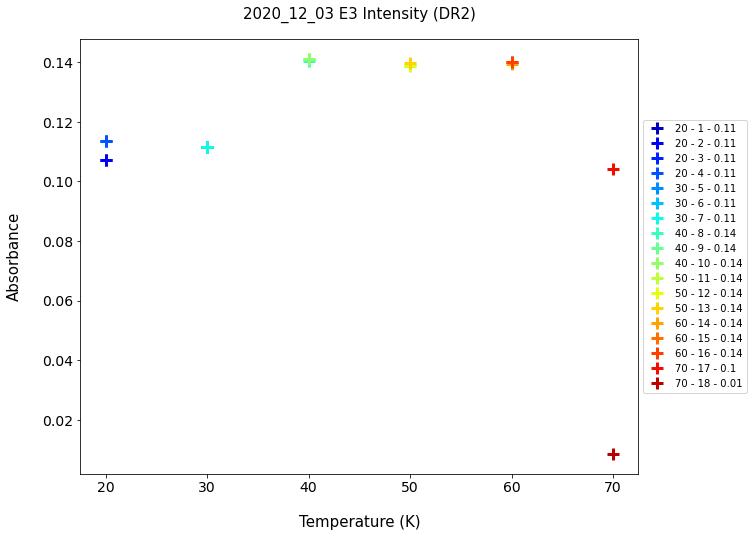

In [111]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,23], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,23]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E3 Intensity (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE3-Abs.png".format(XP,date,date), bbox_inches='tight')


plt.show()

##### sub range 3 frequency

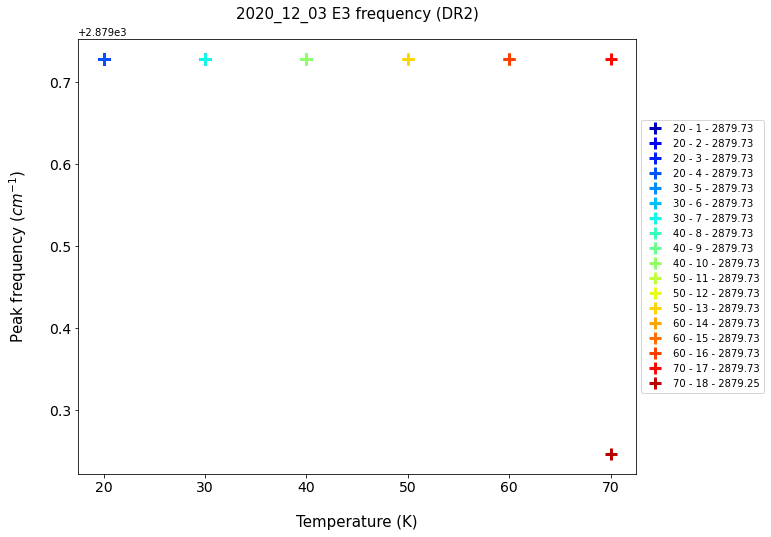

In [116]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,24], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,24]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E3 frequency (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Peak frequency ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE3-freq.png".format(XP,date,date), bbox_inches='tight')


plt.show()

### Sub-range 2

#### Full range

19


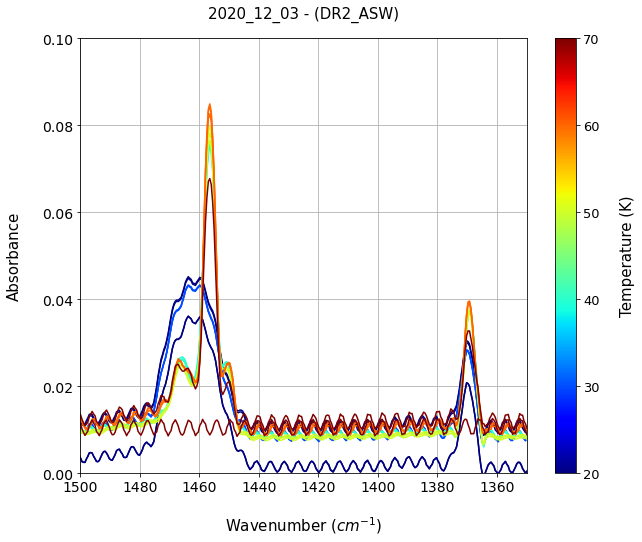

In [113]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=20, vmax=70)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(All_df_BC.Wavenumber, All_df_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(temp)))
    
    
    

plt.title('{0} - (DR2_ASW)'.format(date), fontsize=15, pad=20)
plt.axis([1500,1350,0,0.1])
plt.xlabel('Wavenumber ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
cbar = plt.colorbar(scalarmappaple)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('Temperature (K)', labelpad=20 ,size=15)

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_sub-range_2.png".format(XP,date,date))


plt.show()

#### E4 Intensity

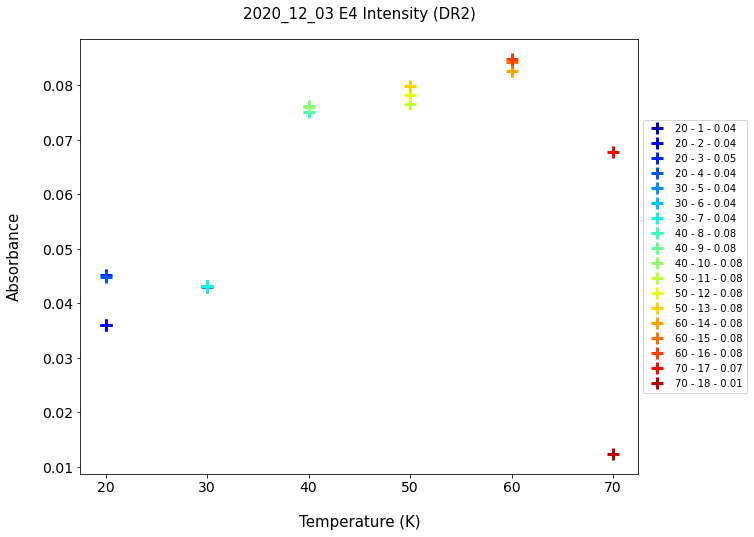

In [114]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,26], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,26]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E4 Intensity (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE4-Abs.png".format(XP,date,date), bbox_inches='tight')


plt.show()

#### E4 frequency

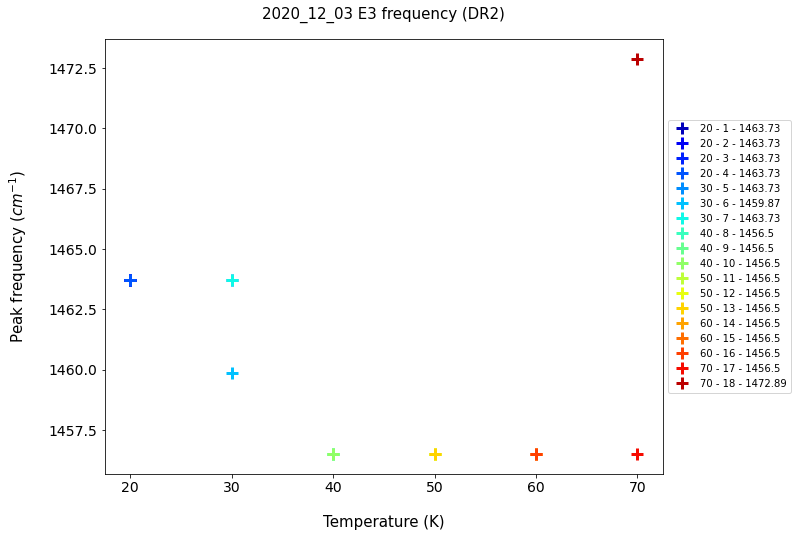

In [117]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,27], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,27]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E4 frequency (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Peak frequency ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE4-freq.png".format(XP,date,date), bbox_inches='tight')


plt.show()

#### E5 Intensity

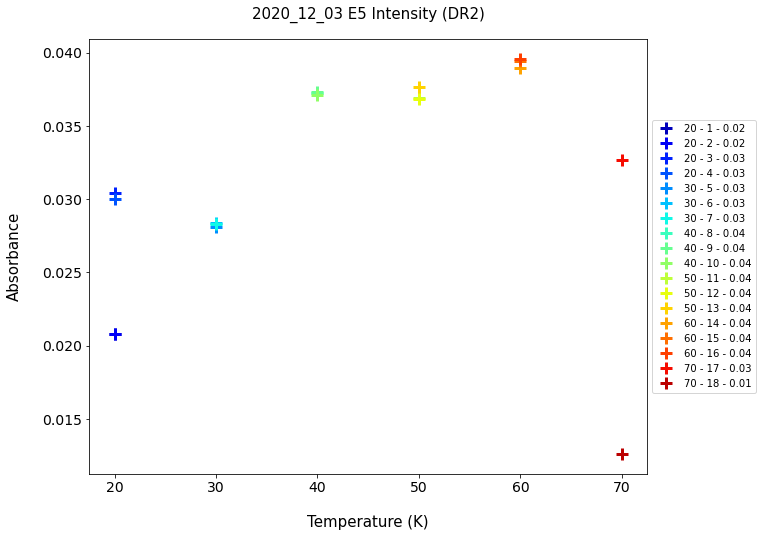

In [118]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,29], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,29]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E5 Intensity (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE5-Abs.png".format(XP,date,date), bbox_inches='tight')


plt.show()

#### E5 frequency

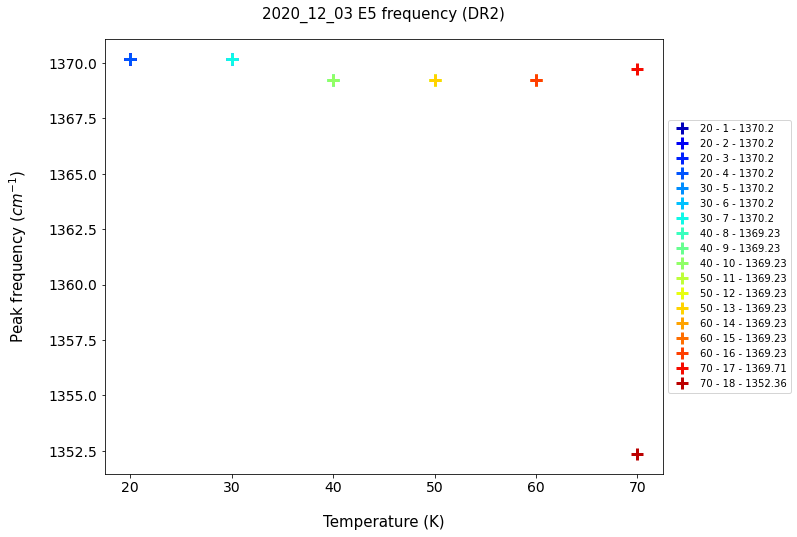

In [119]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,30], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,30]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E5 frequency (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Peak frequency ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE5-freq.png".format(XP,date,date), bbox_inches='tight')


plt.show()

### Sub-range 2

#### Full range

19


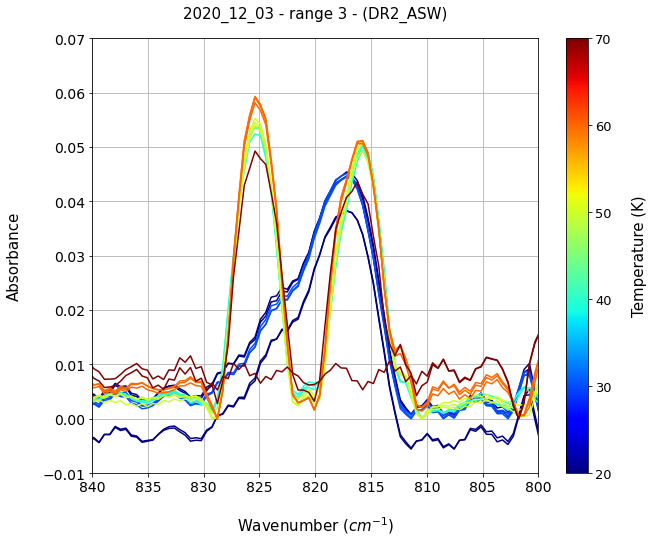

In [122]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=20, vmax=70)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(All_df_BC.Wavenumber, All_df_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(temp)))
    
    
    

plt.title('{0} - range 3 - (DR2_ASW)'.format(date), fontsize=15, pad=20)
plt.axis([840,800,-0.01,0.07])
plt.xlabel('Wavenumber ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
cbar = plt.colorbar(scalarmappaple)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('Temperature (K)', labelpad=20 ,size=15)

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_sub-range_3.png".format(XP,date,date))


plt.show()

#### E6 Intensity

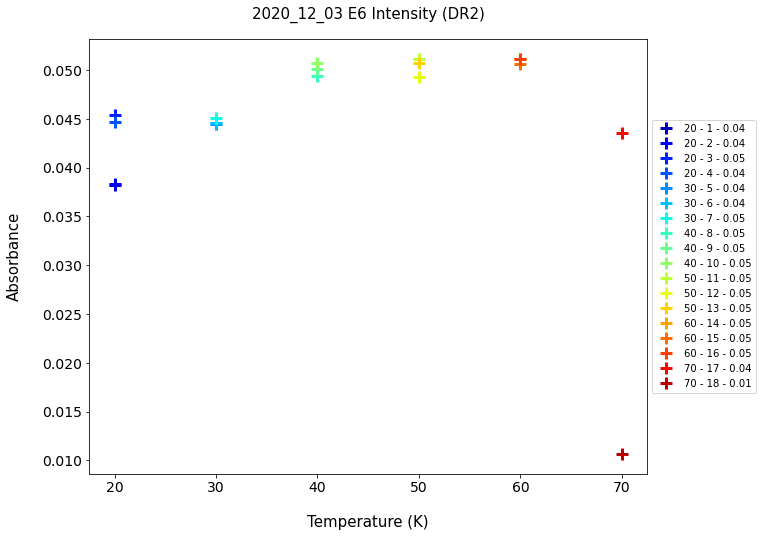

In [123]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,32], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,32]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E6 Intensity (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE6-Abs.png".format(XP,date,date), bbox_inches='tight')


plt.show()

#### E6 frequency

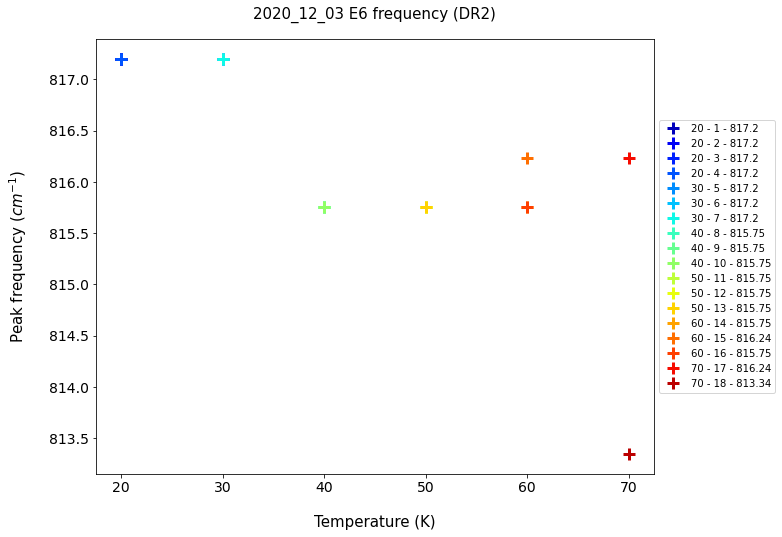

In [124]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,33], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,33]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E6 frequency (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Peak frequency ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE6-freq.png".format(XP,date,date), bbox_inches='tight')


plt.show()

#### E7 Intensity

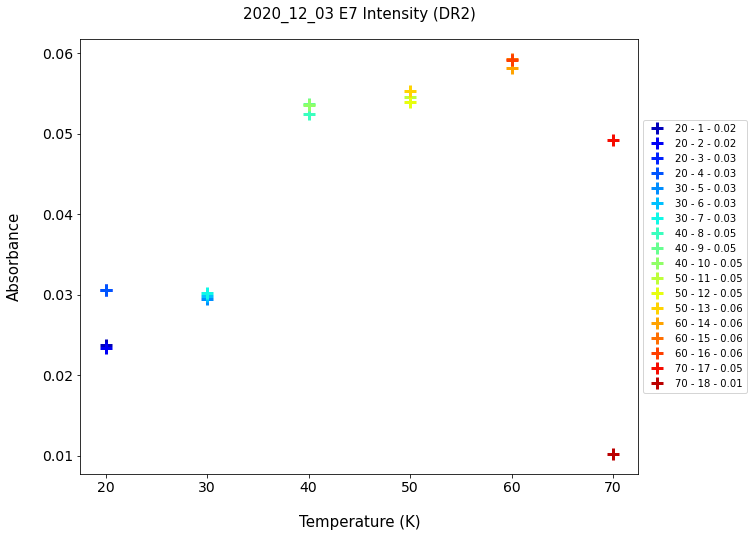

In [125]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,35], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,35]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E7 Intensity (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE7-Abs.png".format(XP,date,date), bbox_inches='tight')


plt.show()

#### E7 frequency

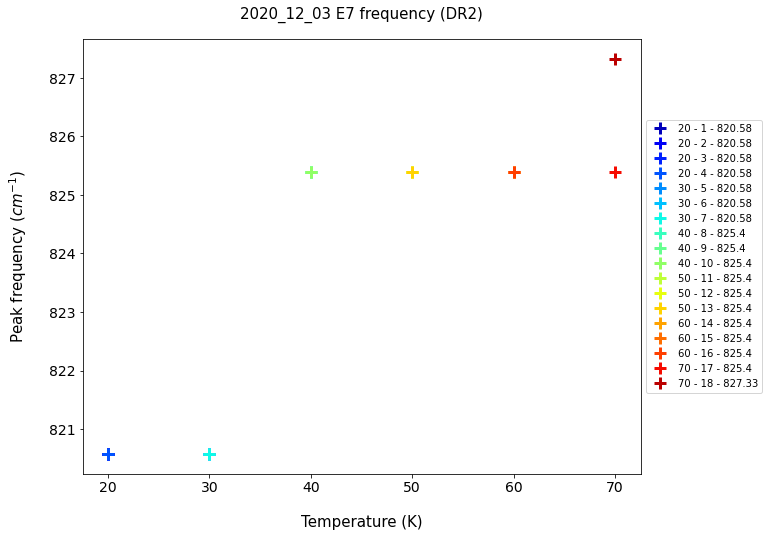

In [126]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    #temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=Tmin, vmax=Tmax)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(keys, data_annex_df.iloc[i-1,36], '+', mew=3, ms=12, c=cm.jet(i/nscan), label= str(keys)+" - "+str(i)+" - "+str(float("{:.2f}".format(data_annex_df.iloc[i-1,36]))))
        
        #plt.plot(keys, data_annex_df.iloc[i,21], '.', mew=3, ms=12, c=cm.jet(i/nscan),label= str(keys)+" - "+str(i+1)+" - "+str(int(data_annex_df.iloc[i,21])))

        
plt.title('{0} E7 frequency (DR2)'.format(date), fontsize=15, pad=20)
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)', labelpad=20).set_fontsize(15)
plt.ylabel('Peak frequency ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
#plt.grid()
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakE7-freq.png".format(XP,date,date), bbox_inches='tight')


plt.show()

###  Export data_annex

<div class="alert alert-block alert-danger">
To do
</div>



***

<img style="float: right;" src="..\..\Docs\Logo_work_in_progress.svg" alt="logo" width="160px"/>

## About this notebook

**Updated On:** 2022-11-10 


**Author:** Vincent Deguin, PhD Student.
<br>
 **Contact:** vincent.deguin@open.ac.uk  
